# Leer datasets

In [25]:
import pandas as pd
import numpy as np

moon = pd.read_csv('../data/moon.csv')
moon.head()

,X1,X2,label
0,0.682988,-0.345203,1
1,2.040990,-0.131615,1
2,-0.139752,0.454391,1
3,0.885748,0.286342,0
4,1.182459,-0.497711,1


In [26]:
moon.drop(columns=['label'], inplace=True)

# Realizamos los clusters

In [27]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(moon)
kmeans_labels = kmeans.labels_
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(moon)
dbscan_labels = dbscan.labels_
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(moon)
gmm_labels = gmm.predict(moon)

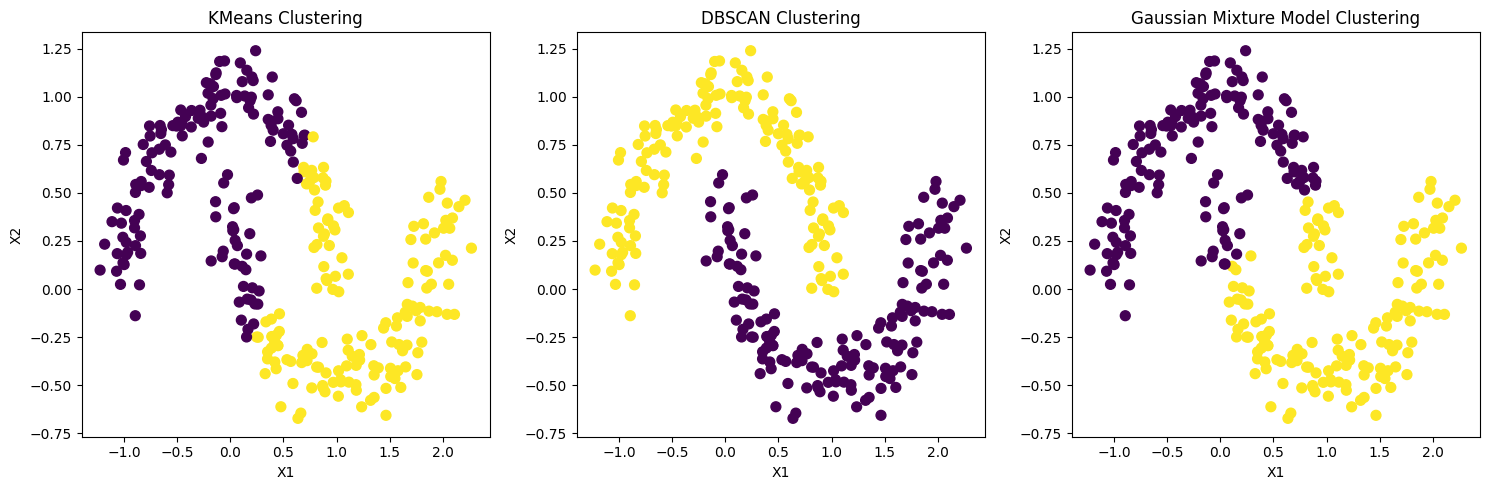

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(moon.iloc[:, 0], moon.iloc[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('KMeans Clustering')
plt.xlabel(moon.columns[0])
plt.ylabel(moon.columns[1])
plt.subplot(1, 3, 2)
plt.scatter(moon.iloc[:, 0], moon.iloc[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel(moon.columns[0])
plt.ylabel(moon.columns[1])
plt.subplot(1, 3, 3)
plt.scatter(moon.iloc[:, 0], moon.iloc[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel(moon.columns[0])
plt.ylabel(moon.columns[1])
plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import silhouette_score
kmeans_silhouette = silhouette_score(moon, kmeans_labels)
dbscan_silhouette = silhouette_score(moon, dbscan_labels)
gmm_silhouette = silhouette_score(moon, gmm_labels)
print(f'KMeans Silhouette Score: {kmeans_silhouette:.2f}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette:.2f}')
print(f'Gaussian Mixture Model Silhouette Score: {gmm_silhouette:.2f}')

KMeans Silhouette Score: 0.48
DBSCAN Silhouette Score: 0.32
Gaussian Mixture Model Silhouette Score: 0.46


# Interpretar

In [30]:
import sys
sys.path.append('..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

## Kmeans

In [31]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(moon, kmeans_labels, test_size=0.2, random_state=42)


In [32]:
#muestrame los centros de los clusters
centers = kmeans.cluster_centers_
print("KMeans Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

KMeans Cluster Centers:
Cluster 0: [-0.20779346  0.59547527]
Cluster 1: [ 1.19079629 -0.07376913]


In [33]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.97


In [34]:
ripper.print_rules()


Reglas para clase: 0
[[X1=-0.84--0.25] V [X1=0.029-0.21] V [X1=<-0.84] V [X1=-0.25-0.029] V [X1=0.21-0.44^X2=0.8-0.91] V [X1=0.21-0.44^X2=>0.91] V [X2=0.15-0.28^X1=0.21-0.44]]

Reglas para clase: 1
[[X1=1.26-1.75] V [X1=0.9-1.26] V [X1=>1.75] V [X1=0.72-0.9] V [X2=-0.41--0.25] V [X2=<-0.41]]


Decision Tree Accuracy: 1.00


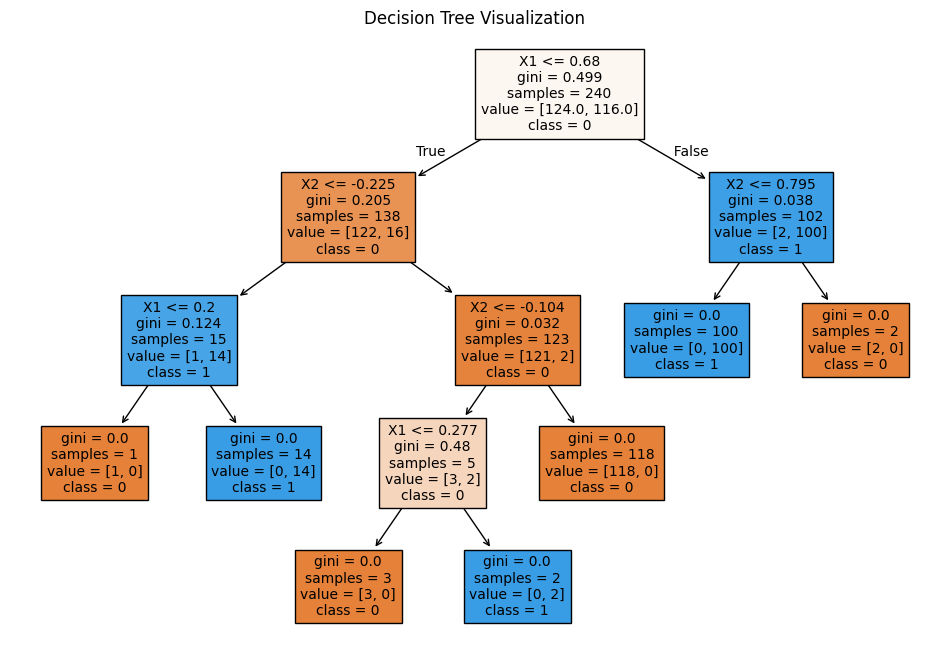

In [35]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=moon.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [36]:
ds = DSClassifierMultiQ(2, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=moon.columns.tolist())


Optimization started

Training time: 8.61s, epochs: 200

Least training loss reached: 0.067


In [37]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.710] R0: X1 < -0.115
			0: 0.710	1: 0.000	Unc: 0.290

	[0.706] R7: X2 > 0.599
			0: 0.706	1: 0.000	Unc: 0.294

	[0.614] R1: -0.115 < X1 < 0.477
			0: 0.614	1: 0.000	Unc: 0.386

Most important rules for class 1

	[0.708] R2: 0.477 < X1 < 1.069
			0: 0.000	1: 0.708	Unc: 0.292

	[0.698] R3: X1 > 1.069
			0: 0.000	1: 0.698	Unc: 0.302

	[0.684] R4: X2 < -0.055
			0: 0.000	1: 0.684	Unc: 0.316


In [38]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.97


## DBSCAN

In [39]:
#dividir los datos en entrenamiento y prueba
n_clusters = len(np.unique(dbscan_labels))
max_label = np.max(dbscan_labels)
dbscan_labels = np.where(dbscan_labels == -1, max_label + 1, dbscan_labels)  # Assign a new label for noise points
X_train, X_test, y_train, y_test = train_test_split(moon, dbscan_labels, test_size=0.2, random_state=42)


In [40]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.98


In [41]:
r = ripper.get_rules()
string = str(r[0])
string1 = str(r[1])
rules = string.split('V')
rules1 = string1.split('V')
print("DBSCAN Ripper Rules:", len(rules))
print("DBSCAN Ripper Rules:", len(rules1))
ripper.print_rules()

DBSCAN Ripper Rules: 14
DBSCAN Ripper Rules: 14

Reglas para clase: 0
[[X2=<-0.41] V [X2=-0.25--0.057] V [X2=-0.41--0.25] V [X1=>1.75] V [X1=0.029-0.21^X2=-0.057-0.15] V [X1=-0.25-0.029^X2=0.28-0.42] V [X1=1.26-1.75] V [X1=0.029-0.21^X2=0.28-0.42] V [X2=0.42-0.58^X1=0.029-0.21] V [X1=-0.25-0.029^X2=0.42-0.58] V [X2=0.15-0.28^X1=0.029-0.21] V [X1=-0.25-0.029^X2=0.15-0.28] V [X1=0.21-0.44^X2=0.15-0.28] V [X1=-0.25-0.029^X2=-0.057-0.15]]

Reglas para clase: 1
[[X1=<-0.84] V [X2=0.8-0.91] V [X2=>0.91] V [X2=0.58-0.8] V [X1=0.72-0.9^X2=0.42-0.58] V [X1=0.9-1.26^X2=-0.057-0.15] V [X1=0.72-0.9^X2=0.15-0.28] V [X2=0.42-0.58^X1=0.9-1.26] V [X1=-0.84--0.25] V [X1=0.72-0.9^X2=-0.057-0.15] V [X2=0.28-0.42^X1=0.9-1.26] V [X1=0.44-0.72^X2=0.42-0.58] V [X1=0.72-0.9^X2=0.28-0.42] V [X1=0.9-1.26^X2=0.15-0.28]]


Decision Tree Accuracy: 0.98


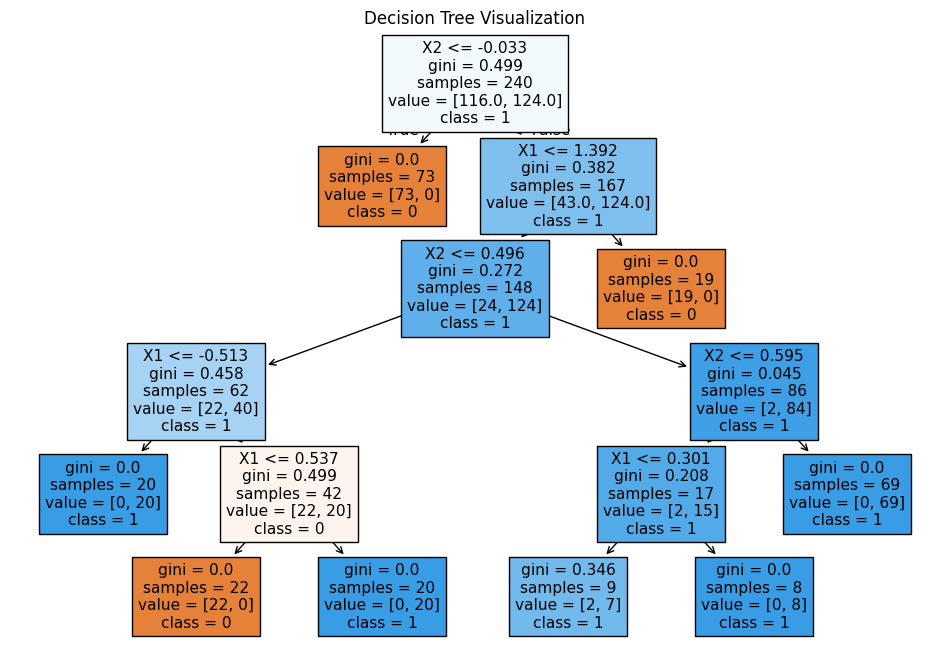

In [42]:
tree = DecisionTreeClassifier(random_state=44, min_samples_leaf=5)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=moon.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [43]:
ds = DSClassifierMultiQ(n_clusters, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=moon.columns.tolist())


Optimization started

Training time: 8.39s, epochs: 200

Least training loss reached: 0.056


In [44]:
ds.print_most_important_rules(threshold=0.001)



Most important rules for class 0

	[0.829] R4: X2 < -0.055
			0: 0.829	1: 0.000	Unc: 0.171

	[0.735] R3: X1 > 1.069
			0: 0.735	1: 0.000	Unc: 0.265

	[0.544] R1: -0.115 < X1 < 0.477
			0: 0.544	1: 0.000	Unc: 0.456

	[0.137] R5: -0.055 < X2 < 0.272
			0: 0.104	1: 0.077	Unc: 0.820

	[0.103] R6: 0.272 < X2 < 0.599
			0: 0.040	1: 0.227	Unc: 0.733

Most important rules for class 1

	[0.806] R7: X2 > 0.599
			0: 0.000	1: 0.806	Unc: 0.194

	[0.642] R0: X1 < -0.115
			0: 0.000	1: 0.642	Unc: 0.358

	[0.625] R2: 0.477 < X1 < 1.069
			0: 0.000	1: 0.625	Unc: 0.375

	[0.246] R6: 0.272 < X2 < 0.599
			0: 0.040	1: 0.227	Unc: 0.733

	[0.118] R5: -0.055 < X2 < 0.272
			0: 0.104	1: 0.077	Unc: 0.820


In [45]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.97


## GMM

In [46]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(moon, gmm_labels, test_size=0.2, random_state=42)


In [47]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 1.00


In [48]:
ripper.print_rules()


Reglas para clase: 0
[[X1=-0.84--0.25] V [X1=<-0.84] V [X2=>0.91] V [X2=0.58-0.8] V [X2=0.8-0.91] V [X1=-0.25-0.029] V [X1=0.029-0.21^X2=0.15-0.28] V [X2=0.42-0.58^X1=0.44-0.72] V [X1=0.029-0.21^X2=0.42-0.58] V [X2=0.42-0.58^X1=0.72-0.9] V [X1=0.029-0.21^X2=0.28-0.42]]

Reglas para clase: 1
[[X2=-0.25--0.057] V [X2=-0.41--0.25] V [X2=<-0.41] V [X1=>1.75] V [X1=0.9-1.26] V [X1=0.72-0.9^X2=0.28-0.42] V [X1=0.72-0.9^X2=0.15-0.28] V [X2=-0.057-0.15^X1=0.72-0.9] V [X2=-0.057-0.15^X1=0.029-0.21] V [X1=1.26-1.75]]


Decision Tree Accuracy: 1.00


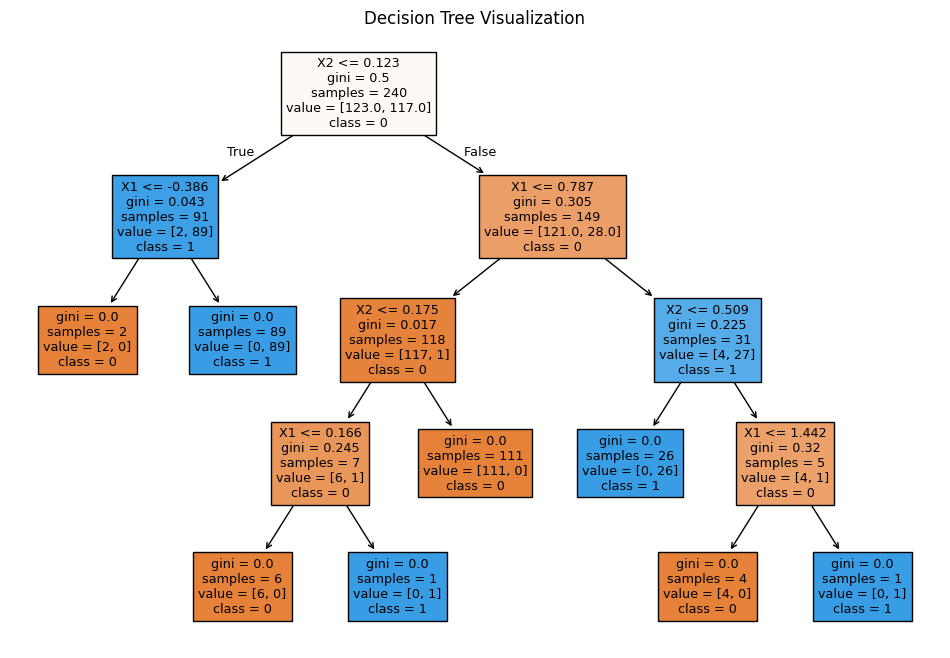

In [49]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=moon.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [50]:
ds = DSClassifierMultiQ(2, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=moon.columns.tolist())


Optimization started

Training time: 8.30s, epochs: 200

Least training loss reached: 0.057


In [51]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.818] R7: X2 > 0.599
			0: 0.818	1: 0.000	Unc: 0.182

	[0.791] R0: X1 < -0.115
			0: 0.791	1: 0.000	Unc: 0.209

	[0.431] R6: 0.272 < X2 < 0.599
			0: 0.431	1: 0.000	Unc: 0.569

Most important rules for class 1

	[0.767] R4: X2 < -0.055
			0: 0.000	1: 0.767	Unc: 0.233

	[0.759] R3: X1 > 1.069
			0: 0.000	1: 0.759	Unc: 0.241

	[0.420] R2: 0.477 < X1 < 1.069
			0: 0.000	1: 0.420	Unc: 0.580

	[0.323] R5: -0.055 < X2 < 0.272
			0: 0.000	1: 0.323	Unc: 0.677


In [52]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.97
